# Introduction

In this notebook, we'll be trying to use the original AIRXD-ML labelling code (written in C) to label Martin's data.

Last time we tried this, there was an issue where the 2theta bins that were generated from 'IOtth' were not represented in the 2theta azimuthal map. This caused a segmentation error in the c code since it could not calculate a median for certain 2theta values that were not represented at all.

The purpose of this code is to first double check that all 2theta bins generated are non-empty

In [120]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import os
from glob import glob

In [121]:
from airxd_cnn.poni_parse import convert_to_imctrl
import airxd
from airxd.mask import MASK

# Defining image size and other metrics for mask

In [37]:
#Importing example images from the RC09 dataset

example_im_dir = 'data/from_martin/Q_MINES_JuneJuly2023_RC09_RawData/'

example_im_files = glob(example_im_dir + '*.Tiff')

example_im = iio.v2.volread(example_im_files[0])
example_im.shape

(1043, 981)

Poni to fit2D conversion + MASK instantiation

In [21]:
poni_path = 'data/from_martin/RC08/Q_MINES_JuneJuly2023_RC08_RawData/Calibration/LaB6_calibration_225mm_30keV.poni'

controls = convert_to_imctrl(poni_path)

#Post-correction of min and max TA values for IOtth
controls['IOtth'] = [65.2, 72.8]

mask = MASK(controls = controls, shape = (1043, 981))

In [22]:
#Based on this result we'll redo the IOtth to respect these values in the above cell.

np.min(mask.TA), np.max(mask.TA)

(65.18528747558594, 72.95048522949219)

In [23]:
#We'll be re-creating parts of "AutoSpotMask" without calling the C code. We're simply constructing the 2theta bins and seeing if every bin has some values in it

numchans = 200
LUtth = np.array(controls['IOtth'])
dtth = (LUtth[1]-LUtth[0])/numchans
TThs = np.linspace(LUtth[0], LUtth[1], numchans, False)


In [24]:
#Flatten mask
hist, _ = np.histogram(mask.TA.ravel(), bins = TThs)

In [34]:
lowest_count_indices = np.argsort(hist)[:10]
print(lowest_count_indices, hist[0])


[0 1 2 3 4 5 6 7 8 9] 49


Looks like we shouldn't be having any sort of binning issues at 200 channels when we run the C code. 

# Checking mask

We seemingly had no issues running the code on his masks. Let's check the result.

In [122]:
from airxd_cnn.transforms import powder_normalize

In [123]:
#Test image
example_im_dir = 'data/from_martin/Q_MINES_JuneJuly2023_RC09_RawData/'
example_im_files = glob(example_im_dir + '*.Tiff')
test_im = iio.v2.volread(example_im_files[0])

#Mask
test_im_mask = np.load('mask_test.npy')

Now I'm checking which pixels to exclude so they're not included in median calc

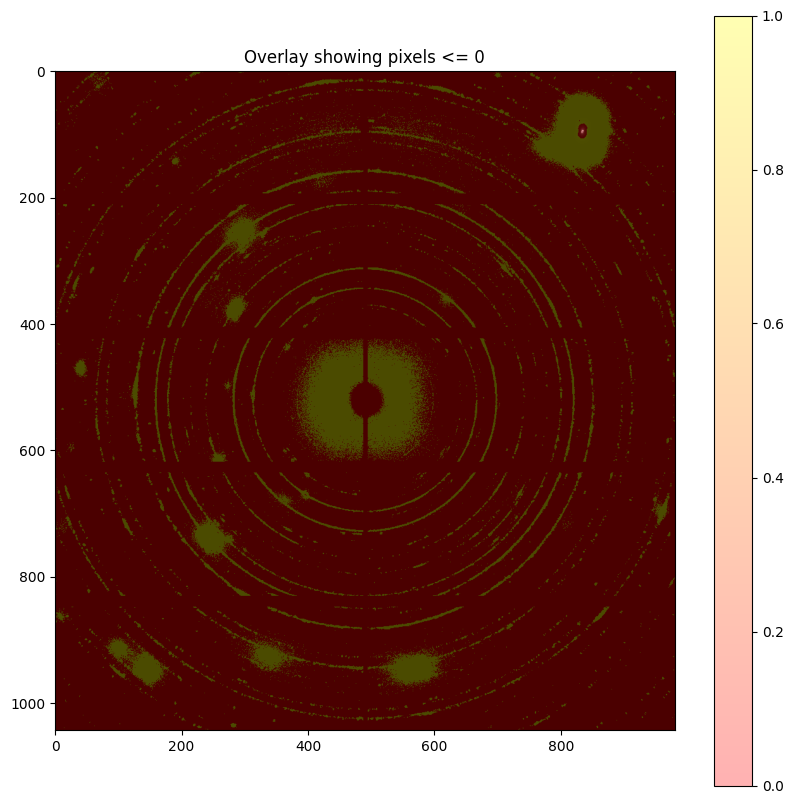

In [97]:
# Create binary mask where pixels <= 0
mask = ((test_im > 200) & (test_im < 2e4)).astype(float)

# Plot overlay
plt.figure(figsize=(10,10))
plt.imshow(test_im, cmap='gray')
plt.imshow(mask, cmap='autumn', alpha=0.3)
plt.colorbar()
plt.title('Overlay showing pixels <= 0')
plt.show()

In [124]:
#Normalize the image so features are more apparent
normalized_test_im = powder_normalize(test_im)

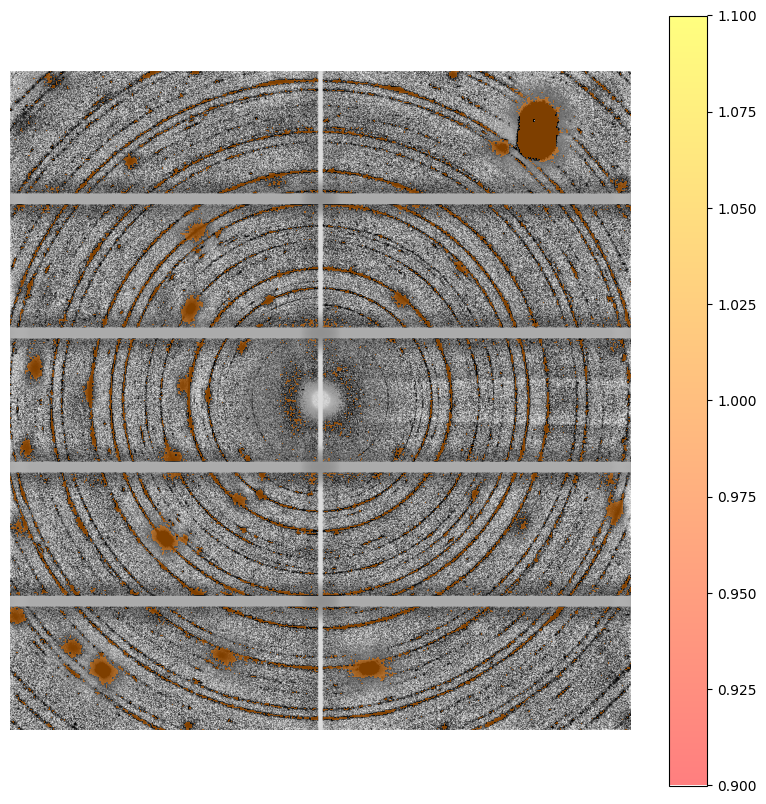

In [125]:
#Plot image with overlay

plt.figure(figsize=(10,10))
plt.imshow(normalized_test_im, cmap='binary', origin='lower',)  # Base image in grayscale
plt.imshow(np.ma.masked_where(test_im_mask == 0, test_im_mask), cmap='autumn', alpha=0.5)  # Mask overlay with transparency
plt.colorbar()
plt.axis('off')
plt.show()

# Gaussian convolutions

In [111]:
from scipy import ndimage

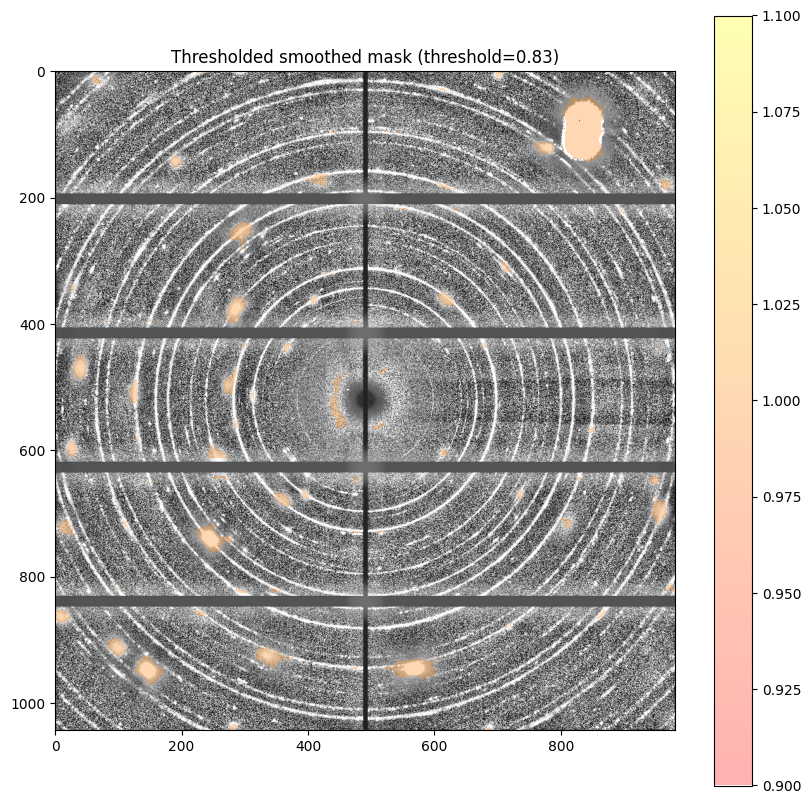

In [130]:
sigma = 3.8  # Adjust this value for different smoothing levels
threshold = 0.83
smoothed_mask = ndimage.gaussian_filter(test_im_mask, sigma=sigma)

thresholded_mask = (smoothed_mask > threshold).astype(float)

# Visualize result
plt.figure(figsize=(10,10))
plt.imshow(normalized_test_im, cmap='gray')
plt.imshow(np.ma.masked_where(thresholded_mask == 0, thresholded_mask), cmap='autumn', alpha=0.3)
plt.colorbar()
plt.title(f'Thresholded smoothed mask (threshold={threshold})')
plt.show()

# Pipeline to convert all other images    

In [ ]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import os
from glob import glob
from airxd_cnn.poni_parse import convert_to_imctrl
import airxd
from airxd.mask import MASK

In [142]:
#Controls pathing
control_path = 'data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/Calibration/LaB6_calibration_225mm_30keV.poni'
controls = convert_to_imctrl(control_path)
controls['IOtth'] = [65.2, 72.95]

#Median filter parameters
numChans = 500

#Convolution parameters
sigma = 3.8  # Adjust this value for different smoothing levels
threshold = 0.83

In [144]:
base_dir = 'data/from_martin'

sub_dir = glob(base_dir + '/*')

for dir in sub_dir:
    im_list = glob(dir + '/*.Tiff')

    for im_path in im_list:
        print(im_path)
        im = iio.v2.volread(im_path)
        im = powder_normalize(im)

        #Median filter
        mask = MASK(controls, shape= im.shape)
        result = mask.AutoSpotMask(im, esdmul = 2.0, numchans=numChans)

        #Convolution masking
        smoothed_mask = ndimage.gaussian_filter(result, sigma=sigma)
        thresholded_mask = (smoothed_mask > threshold).astype(float)

        #Get save path
        im_name = im_path.split('/')[-1]
        im_name = im_name.replace('.Tiff', '')
        save_path = os.path.join(dir, 'masks', im_name)

        #Save the result
        np.save(save_path, thresholded_mask)

data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0005.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 500
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0019.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 500
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0023.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 500
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0013.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 500
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0008.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 500
Starting up C code
data/from_martin/Q_MINES_

In [ ]:
def view_im_and_mask(im_path, mask_path):
    im_name = im_path.split('/')[-1].replace('.Tiff', '')

    #Load image and mask
    im = iio.v2.volread(im_path)
    normalized_im = powder_normalize(im)
    mask = np.load(mask_path)

    # Visualize result
    plt.figure(figsize=(10,10))
    plt.imshow(normalized_im, cmap='gray')
    plt.imshow(np.ma.masked_where(mask == 0, mask), cmap='autumn', alpha=0.3)
    # plt.colorbar()
    plt.title(f'Image {im_name[:30]}, threshold={threshold})')
    plt.show()

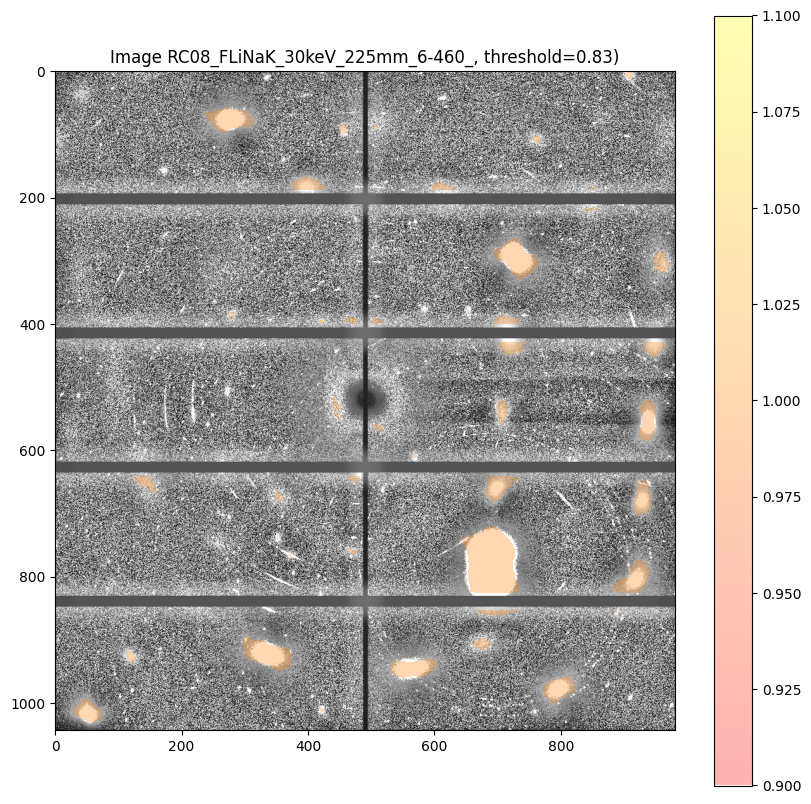

In [151]:
#Image info
sub_index = 0 #Sub directory index
image_index = 0 #Image index within sub directory

#Directory info
base_dir = 'data/from_martin'
sub_dir = glob(base_dir + '/*')
im_list = glob(sub_dir[sub_index] + '/*.Tiff')

#Getting paths of mask and image
im_path = im_list[image_index]
im_name = im_path.split('/')[-1].replace('.Tiff', '')
mask_path = os.path.join(sub_dir[sub_index], 'masks', im_name + '.npy')

view_im_and_mask(im_path, mask_path)

